In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle
def save_data(data, outfile):
    with open(outfile, 'wb') as outf:
        pickle.dump(data, outf)

def load_data(infile):
    with open(infile, 'rb') as inf:
        data = pickle.load(inf)
    return data


In [3]:
import time
loca = time.strftime('%Y-%m-%d')

In [4]:
#https://annovar.openbioinformatics.org/en/latest/user-guide/gene/
dict_gene1 = {
    #'Func.refGene',
    'stream':5,
    'exonic':1,
    'intergenic':6,
    'intronic':4,
    'ncRNA':2,
    'splicing':1,
    'UTR':3,
}
dict_gene2={
    '.':12,
    #'ExonicFunc.refGene',
    'frameshift deletion':2,
    'frameshift insertion':1,
    'frameshift substitution':3,
    'nonframeshift deletion':7,
    'nonframeshift insertion':6,
    'nonframeshift substitution':8,
    'nonsynonymous SNV':9,
    'synonymous SNV':10,
    'stopgain':4,
    'stoploss':5,
    'startloss':0,
    'unknown':11
}

In [5]:
tag_list=['Pathogenic','Likely_pathogenic','Pathogenic/Likely_pathogenic',
         'Benign','Likely_benign','Benign/Likely_benign']

In [6]:
#https://www.ncbi.nlm.nih.gov/clinvar/docs/review_status/
dict_CLNREVSTAT={
    'criteria_provided,_single_submitter':1,
    'no_assertion_criteria_provided':0,
    'criteria_provided,_multiple_submitters,_no_conflicts':2,
    'reviewed_by_expert_panel':3,
    'practice_guideline':4
}

In [7]:
columns_list = ['CHR', 'POS', 'REF', 'ALT', 'Func.refGene', 'Gene.refGene', 
                'ExonicFunc.refGene', 'controls_AF_popmax', 'Length', 'MultOf3',
                'exonic', 'stream', 'intergenic', 'intronic', 'ncRNA', 'splicing',
                'UTR', 'frameshift deletion', 'frameshift insertion',
                'nonframeshift deletion', 'nonframeshift insertion', 'startloss',
                'stopgain', 'stoploss', 'Func_b', 'Func_p', 'ExonicFunc_b', 'ExonicFunc_p', 'tag']
rename_col = ['CHR', 'POS', 'REF', 'ALT', 'Func.refGene', 'Gene.refGene',
              'ExonicFunc.refGene', 'AF', 'length', 'MultOf3',
              'exonic', 'stream', 'intergenic', 'intronic', 'ncRNA', 'splicing',
              'UTR', 'frameshift_deletion', 'frameshift_insertion',
              'nonframeshift_deletion', 'nonframeshift_insertion', 'startloss',
              'stopgain', 'stoploss', 'Func_b', 'Func_p', 'ExonicFunc_b', 'ExonicFunc_p', 'tag']

# function used in preprocess

In [8]:
P_ig_pivot_Func, P_ig_pivot_exonicFunc, dic_func_b, dic_func_p, dic_exon_func_b, dic_exon_func_p = load_data("/hwfssz1/ST_HEALTH/P20Z10200N0170/weiyilin/project/INDELpred/pipeline/model/func_feature.pkl")
fill_values_Func = P_ig_pivot_Func.fillna(0).mean(numeric_only=True)
fill_values_exonicFunc = P_ig_pivot_exonicFunc.fillna(0).mean(numeric_only=True)

In [9]:
def process_dataframe(df):
    column_mapping = {
        'Otherinfo4': 'CHR',
        'Otherinfo5': 'POS',
        'Otherinfo7': 'REF',
        'Otherinfo8': 'ALT'
    }
    df = df.rename(columns=column_mapping)
    df['Length'] = (df['REF'].str.len() - df['ALT'].str.len()).abs()
    df['MultOf3'] = (df['Length'] % 3 == 0).astype(int)
    values_to_remove = ['nonframeshift substitution', 'frameshift substitution', 'nonsynonymous SNV', 'synonymous SNV']
    df = df[~df['ExonicFunc.refGene'].isin(values_to_remove)]
    return df

# Example usage:
# processed_total = process_dataframe(total)


In [10]:
def compute_func_score(df):
    """
    Compute the func score for a given dataframe.

    Parameters:
    - df: pandas DataFrame to be processed.
    - model_path: path to the func feature model.

    Returns:
    - Processed pandas DataFrame with computed func score.
    """
    
    # Combine stream, UTR, ncRNA, and exonic
    df['Func.refGene'] = df['Func.refGene'].str.replace(r'.*UTR.*', 'UTR', regex=True)
    df['Func.refGene'] = df['Func.refGene'].str.replace(r'.*ncRNA.*', 'ncRNA', regex=True)
    df['Func.refGene'] = df['Func.refGene'].str.replace(r'.*stream.*', 'stream', regex=True)
    df['Func.refGene'] = df['Func.refGene'].str.replace(r'.*exonic.*', 'exonic', regex=True)

    # Merge calculated P_ig_pivot_(exonic)Func
    df = df.merge(P_ig_pivot_Func, on='Gene.refGene', how='left')
    df = df.merge(P_ig_pivot_exonicFunc, on='Gene.refGene', how='left')

    # Fill missing values in P_ig_pivot_(exonic)Func
    for col in fill_values_Func.index:
        df[col].fillna(fill_values_Func[col], inplace=True)
    for col in fill_values_exonicFunc.index:
        df.loc[df['Func.refGene'] != 'exonic', col] = 0
        df.loc[df['Func.refGene'] == 'exonic', col] = fill_values_exonicFunc[col]
    
    return df

# Example usage:
# processed_total = compute_func_score(total)


In [11]:
# Function to replace data based on predefined dictionaries
def func_replace(data):
    data['Func_b'] = data['Func.refGene'].replace(dic_func_b)
    data['Func_p'] = data['Func.refGene'].replace(dic_func_p)
    data['Func'] = data['Func.refGene'].replace(dict_gene1)
    data['ExonicFunc_b'] = data['ExonicFunc.refGene'].replace(dic_exon_func_b)
    data['ExonicFunc_p'] = data['ExonicFunc.refGene'].replace(dic_exon_func_p)
    data['ExonicFunc'] = data['ExonicFunc.refGene'].replace(dict_gene2)
    return data

# Example usage:
# func_replace(total)

# ClinvarTrain

In [16]:
trian_path = '../database/clinvar_20211009_indel.hg19_multianno.txt'
total = pd.read_table(trian_path)


/tmp/ipykernel_49076/4149665268.py:2: DtypeWarning: Columns (0,55) have mixed types. Specify dtype option on import or set low_memory=False.
  total = pd.read_table(trian_path)


In [17]:
# 提取筛选所需特征
total['CLNREVSTAT'] = total['Otherinfo11'].str.extract(r'CLNREVSTAT=(.*?);')
total['CLNSIG'] = total['Otherinfo11'].str.extract(r'CLNSIG=(.*?);')
total = process_dataframe(total)

In [21]:
# 筛选
criteria = ['criteria_provided,_single_submitter',
            'criteria_provided,_multiple_submitters,_no_conflicts',
            'reviewed_by_expert_panel']
values_to_remove = ['nonframeshift substitution', 'frameshift substitution', 'nonsynonymous SNV', 'synonymous SNV']

total = total[(total['CLNREVSTAT'].isin(criteria))]
total = total[(total['Length'] <= 1000) & (total['Length'] > 0)]
total = total[~total['ExonicFunc.refGene'].isin(values_to_remove)]
total = total[total['Chr'].isin(list(range(1, 22)) + ['X', 'Y'])]

calculate P_{ig}

In [22]:
total['Func.refGene'] = total['Func.refGene'].str.replace(r'.*UTR.*', 'UTR')
total['Func.refGene'] = total['Func.refGene'].str.replace(r'.*ncRNA.*', 'ncRNA')
total['Func.refGene'] = total['Func.refGene'].str.replace(r'.*stream.*', 'stream')
total['Func.refGene'] = total['Func.refGene'].str.replace(r'.*exonic.*', 'exonic')

/tmp/ipykernel_49076/3822539340.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  total['Func.refGene'] = total['Func.refGene'].str.replace(r'.*UTR.*', 'UTR')
/tmp/ipykernel_49076/3822539340.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  total['Func.refGene'] = total['Func.refGene'].str.replace(r'.*ncRNA.*', 'ncRNA')
/tmp/ipykernel_49076/3822539340.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  total['Func.refGene'] = total['Func.refGene'].str.replace(r'.*stream.*', 'stream')
/tmp/ipykernel_49076/3822539340.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  total['Func.refGene'] = total['Func.refGene'].str.replace(r'.*exonic.*', 'exonic')


In [23]:
# caluculate Func P_{ig}
N_pig = total[total['CLNSIG'].isin(['Pathogenic','Likely_pathogenic'])].groupby(['Gene.refGene', 'Func.refGene']).size()
N_ig = total.groupby(['Gene.refGene', 'Func.refGene']).size()
P_ig = N_pig / N_ig
P_ig = P_ig.reset_index(name='P_ig')
P_ig_pivot_Func = P_ig.pivot(index='Gene.refGene', columns='Func.refGene', values='P_ig').reset_index()
total = total.merge(P_ig_pivot_Func, on='Gene.refGene', how='left')

In [24]:
# calculate ExonicFunc P_{ig}
N_pig = total[total['CLNSIG'].isin(['Pathogenic','Likely_pathogenic'])].groupby(['Gene.refGene', 'ExonicFunc.refGene']).size()
N_ig = total.groupby(['Gene.refGene', 'ExonicFunc.refGene']).size()
P_ig = N_pig / N_ig
P_ig = P_ig.reset_index(name='P_ig')
P_ig_pivot_exonicFunc = P_ig.pivot(index='Gene.refGene', columns='ExonicFunc.refGene', values='P_ig').reset_index()
total = total.merge(P_ig_pivot_exonicFunc, on='Gene.refGene', how='left')

custom funcation-based score

In [25]:
p_list=['Pathogenic','Likely_pathogenic','Pathogenic/Likely_pathogenic']
b_list=['Benign','Likely_benign','Benign/Likely_benign']
total.loc[total['CLNSIG'].isin(p_list),'tag']=1
total.loc[total['CLNSIG'].isin(b_list),'tag']=0
total['tag'].fillna(-9, inplace=True)

In [26]:
func_sta=pd.concat([
    pd.DataFrame(total[total['tag']==0]['Func.refGene'].value_counts()),
    pd.DataFrame(total[total['tag']==1]['Func.refGene'].value_counts()),
    pd.DataFrame(total[total['tag']==-9]['Func.refGene'].value_counts()),
],axis=1)
func_sta.columns=['benign','pathogenic','other']
for column in func_sta.columns:
    func_sta[column].fillna(0, inplace=True)
func_sta

,benign,pathogenic,other
intronic,21768,234,1622
UTR,2518,26,3288
exonic,2126,40939,10369
ncRNA,835,45,235
stream,601,109,137
splicing,262,809,338
intergenic,9,3,7


/jdfssz1/ST_HEALTH/P20Z10200N0041/Weiyilin/software/mambaforge/envs/sc/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


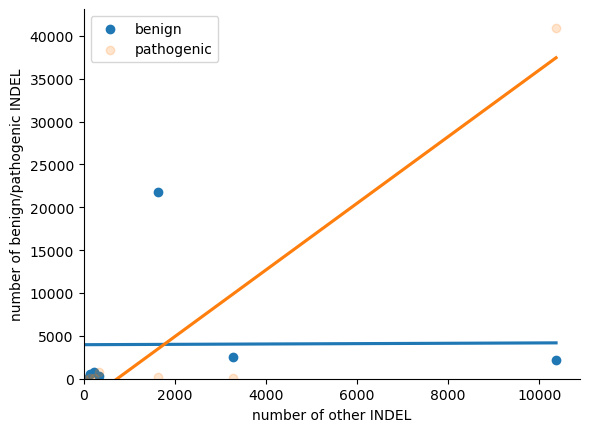

In [19]:
positive_id = func_sta
plt.scatter('other','benign',data=positive_id)
sns.regplot('other','benign',data=positive_id,order=1,ci=None,
                scatter=False)
plt.scatter('other','pathogenic',data=positive_id,alpha=0.2)
sns.regplot('other','pathogenic',data=positive_id,order=1,ci=None,
                scatter=False)
plt.legend(loc='upper left')
plt.ylabel('number of benign/pathogenic INDEL')
plt.xlabel('number of other INDEL')
plt.xlim(-1,)
plt.ylim(-1,)

plt.savefig(f"../final_fig/ols_func_{loca}.pdf", format="pdf", dpi=1000, bbox_inches='tight')
sns.despine()

In [27]:
exon_func_sta=pd.concat([
    pd.DataFrame(total[total['tag']==0]['ExonicFunc.refGene'].value_counts()),
    pd.DataFrame(total[total['tag']==1]['ExonicFunc.refGene'].value_counts()),
    pd.DataFrame(total[total['tag']==-9]['ExonicFunc.refGene'].value_counts()),
],axis=1)
exon_func_sta.columns=['benign','pathogenic','other']
for column in exon_func_sta.columns:
    exon_func_sta[column].fillna(0, inplace=True)
exon_func_sta

,benign,pathogenic,other
.,26007,1302,5634
unknown,925,15701,4459
nonframeshift deletion,527,651,2601
nonframeshift insertion,338,115,950
frameshift deletion,196,15650,1473
frameshift insertion,91,7047,709
stopgain,27,1612,135
stoploss,4,54,25
startloss,4,33,10


In [20]:
positive_id = exon_func_sta
plt.scatter('other','benign',data=positive_id)
sns.regplot('other','benign',data=positive_id,order=1,ci=None,
                scatter=False,)
plt.scatter('other','pathogenic',data=positive_id,alpha=0.2)
sns.regplot('other','pathogenic',data=positive_id,order=1,ci=None,
                scatter=False,)
plt.legend(loc='upper left')
plt.ylabel('number of benign/pathogenic INDEL')
plt.xlabel('number of other INDEL')
plt.xlim(-1,)
plt.ylim(-1,)

plt.savefig(f"../final_fig/ols_exonfunc_{loca}.pdf", format="pdf", dpi=1000, bbox_inches='tight')
sns.despine()

NameError: name 'exon_func_sta' is not defined

In [28]:

from statsmodels.formula.api import ols
lm = ols('benign ~ other ', data=func_sta).fit()
stud_res = lm.outlier_test()
dic_func_b = dict(zip(stud_res.index,stud_res['student_resid']))

lm = ols('pathogenic ~ other ', data=func_sta).fit()
stud_res = lm.outlier_test()
dic_func_p = dict(zip(stud_res.index,stud_res['student_resid']))

lm = ols('benign ~ other ', data=exon_func_sta).fit()
stud_res = lm.outlier_test()
dic_exon_func_b = dict(zip(stud_res.index,stud_res['student_resid']))

lm = ols('pathogenic ~ other ', data=exon_func_sta).fit()
stud_res = lm.outlier_test()
dic_exon_func_p = dict(zip(stud_res.index,stud_res['student_resid']))

In [29]:

save_data([P_ig_pivot_Func, P_ig_pivot_exonicFunc, dic_func_b, dic_func_p, dic_exon_func_b, dic_exon_func_p], f"../data2023/func_feature_{loca}.pkl")


In [29]:
def func_replace(data):
    data['Func_b'] = data['Func.refGene'].replace(dic_func_b)
    data['Func_p'] = data['Func.refGene'].replace(dic_func_p)
    data['Func'] = data['Func.refGene'].replace(dict_gene1)
    data['ExonicFunc_b'] = data['ExonicFunc.refGene'].replace(dic_exon_func_b)
    data['ExonicFunc_p'] = data['ExonicFunc.refGene'].replace(dic_exon_func_p)
    data['ExonicFunc'] = data['ExonicFunc.refGene'].replace(dict_gene2)
    return data
func_replace(total)

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,stopgain,stoploss,unknown,tag,Func_b,Func_p,Func,ExonicFunc_b,ExonicFunc_p,ExonicFunc
0,1,865602,865607,GAACTC,TTCTTCTG,exonic,SAMD11,.,unknown,UNKNOWN,...,NaN,NaN,NaN,-9.0,-0.787253,35.493464,1,-2.898295,1.725787,11
1,1,871246,871246,-,GCAGCCTGGAGATTGGCCT,exonic,SAMD11,.,unknown,UNKNOWN,...,NaN,NaN,NaN,-9.0,-0.787253,35.493464,1,-2.898295,1.725787,11
2,1,874778,874778,-,CCTCCCCAGCCACGGTGAGGACCCACCCTGGCATGATCCCCCTCATCA,exonic,SAMD11,.,unknown,UNKNOWN,...,NaN,NaN,NaN,0.0,-0.787253,35.493464,1,-2.898295,1.725787,11
3,1,874778,874778,-,CCTCCCCAGCCACGGTGAGGACCCACCCTGGCATGATCCCCCTCAT...,exonic,SAMD11,.,unknown,UNKNOWN,...,NaN,NaN,NaN,0.0,-0.787253,35.493464,1,-2.898295,1.725787,11
4,1,874779,874826,CCTCCCCAGCCACGGTGAGGACCCACCCTGGCATGATCCCCCTCATCA,-,exonic,SAMD11,.,unknown,UNKNOWN,...,NaN,NaN,NaN,0.0,-0.787253,35.493464,1,-2.898295,1.725787,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86275,X,154490101,154490103,CTC,-,exonic,RAB39B,.,unknown,UNKNOWN,...,NaN,NaN,NaN,-9.0,-0.787253,35.493464,1,-2.898295,1.725787,11
86276,X,154490633,154490633,-,T,intronic,RAB39B,.,.,.,...,NaN,NaN,NaN,0.0,24.763294,-0.606064,4,217.741516,-1.831591,12
86277,X,154736592,154736593,AT,-,exonic,TMLHE,.,frameshift deletion,TMLHE:NM_001184797:exon6:c.961_962del:p.V321Lf...,...,NaN,NaN,NaN,1.0,-0.787253,35.493464,1,-0.315698,2.222442,2
86278,Y,2655075,2655075,G,-,exonic,SRY,.,frameshift deletion,SRY:NM_003140:exon1:c.570delG:p.K190fs,...,NaN,NaN,NaN,-9.0,-0.787253,35.493464,1,-0.315698,2.222442,2


In [30]:
total = total.loc[:,columns_list]

In [31]:
train_data = total.loc[total['tag'].isin([0, 1]),]
train_data.columns= rename_col
train_data = train_data.replace('.', np.nan)

for column in train_data.columns[7:]:
    train_data[column] = pd.to_numeric(train_data[column])
    train_data[column].fillna(0, inplace=True)
    

In [32]:
x_train = train_data.iloc[:, 7:]
y_train = train_data['tag']
x_train = x_train.drop(['tag'], axis=1)
save_data([x_train, y_train], f'../data2023/train_{loca}.pkl')

In [35]:
%run 1_INDELpred_train_231008.py

# ClinVarTest

In [12]:
test1_path = '../database/clinvar_20230806_indel_no_train.hg19_multianno.txt'
total = pd.read_table(test1_path)

/tmp/ipykernel_42667/1499244390.py:2: DtypeWarning: Columns (0,55) have mixed types. Specify dtype option on import or set low_memory=False.
  total = pd.read_table(test1_path)


In [13]:
# 提取特征
total['CLNREVSTAT'] = total['Otherinfo11'].str.extract(r'CLNREVSTAT=(.*?);')
total['CLNSIG'] = total['Otherinfo11'].str.extract(r'CLNSIG=(.*?);')
total = process_dataframe(total)

In [14]:
total = compute_func_score(total)

In [15]:
p_list=['Pathogenic','Likely_pathogenic','Pathogenic/Likely_pathogenic']
b_list=['Benign','Likely_benign','Benign/Likely_benign']
total.loc[total['CLNSIG'].isin(p_list),'tag']=1
total.loc[total['CLNSIG'].isin(b_list),'tag']=0
total['tag'].fillna(-9, inplace=True)

In [16]:
func_replace(total)
total.head()

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,stopgain,stoploss,unknown,tag,Func_b,Func_p,Func,ExonicFunc_b,ExonicFunc_p,ExonicFunc
0,1,865517,865519,CTC,-,intronic,SAMD11,.,.,.,...,0.000000,0.000000,0.000000,0.0,24.777888,-0.601432,4,218.599959,-1.831600,12
1,1,865591,865593,GAA,-,exonic,SAMD11,.,unknown,UNKNOWN,...,0.070658,0.008043,0.191249,-9.0,-0.780927,35.482988,1,-2.902486,1.728532,11
2,1,865709,865710,AA,-,exonic,SAMD11,.,unknown,UNKNOWN,...,0.070658,0.008043,0.191249,-9.0,-0.780927,35.482988,1,-2.902486,1.728532,11
3,1,871225,871225,-,GCC,exonic,SAMD11,.,unknown,UNKNOWN,...,0.070658,0.008043,0.191249,-9.0,-0.780927,35.482988,1,-2.902486,1.728532,11
4,1,871290,871316,GGGGCCTGAGGGCGGGGTCGGGGCTGT,-,intronic,SAMD11,.,.,.,...,0.000000,0.000000,0.000000,0.0,24.777888,-0.601432,4,218.599959,-1.831600,12


In [17]:
# 添加sub的列
TSG = pd.read_csv('../database/TSG.gene', squeeze=True)
ONC = pd.read_csv('../database/ONC.gene', squeeze=True)
total['TumorGeneType'] = 'Other' 
total.loc[total['Gene.refGene'].isin(TSG), 'TumorGeneType'] = 'TSG'
total.loc[total['Gene.refGene'].isin(ONC), 'TumorGeneType'] = 'ONC'

/tmp/ipykernel_42667/3502338187.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  TSG = pd.read_csv('../database/TSG.gene', squeeze=True)
/tmp/ipykernel_42667/3502338187.py:3: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  ONC = pd.read_csv('../database/ONC.gene', squeeze=True)


In [18]:
# 添加sub的列
grouped_tags = total.groupby('Gene.refGene')['tag'].unique()
genes_with_both_tags = grouped_tags[grouped_tags.apply(lambda x: set(x) == {0, 1})].index
total['SameGene'] = total['Gene.refGene'].apply(lambda x: 1 if x in genes_with_both_tags else 0)

In [19]:
columns_list_plus = columns_list + ['CLNREVSTAT', 'TumorGeneType', 'SameGene']
rename_col_plus = rename_col + ['star', 'TumorGeneType', 'SameGene']

In [20]:
total = total.loc[:,columns_list_plus]
ClinVar = total.loc[total['tag'].isin([0,1]),]
ClinVar['CLNREVSTAT'].replace(dict_CLNREVSTAT, inplace=True)
ClinVar.columns=rename_col_plus
ClinVar = ClinVar.replace('.', np.nan)

for column in ClinVar.columns[7:-2]:
    ClinVar[column] = pd.to_numeric(ClinVar[column])
    ClinVar[column].fillna(0, inplace=True)

/tmp/ipykernel_42667/1279167112.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ClinVar['CLNREVSTAT'].replace(dict_CLNREVSTAT, inplace=True)


In [21]:
ClinVar.to_csv(f'../data2024/ClinVar_max_info_{loca}.csv', index=None)

In [22]:
x_ClinVar = ClinVar.iloc[:, 7:-4]
y_ClinVar = ClinVar['tag']
save_data([x_ClinVar, y_ClinVar],f'../data2024/ClinVar_test_{loca}.pkl')

# VKGLTest

In [12]:
test2_path = '../database/VKGL_public_consensus_202307_indel.sorted.no_train.hg19_multianno.txt'
total = pd.read_table(test2_path, )

In [13]:
# 提取特征
total['support'] = total['Otherinfo11'].str.extract(r'support=(.*?);')
total['classification'] = total['Otherinfo11'].str.extract(r'classification=(.*?)$')
total = process_dataframe(total)
total = compute_func_score(total)

In [14]:
p_list=['P','LP']
b_list=['B','LB']
total.loc[total['classification'].isin(p_list),'tag']=1
total.loc[total['classification'].isin(b_list),'tag']=0
total['tag'].fillna(-9, inplace=True)

In [15]:
func_replace(total)
total.head()

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,stopgain,stoploss,unknown,tag,Func_b,Func_p,Func,ExonicFunc_b,ExonicFunc_p,ExonicFunc
0,1,878052,878052,G,-,exonic,SAMD11,.,unknown,UNKNOWN,...,0.070658,0.008043,0.191249,-9.0,-0.780927,35.482988,1,-2.902486,1.728532,11
1,1,980806,980806,-,T,exonic,AGRN,.,unknown,UNKNOWN,...,0.070658,0.008043,0.191249,-9.0,-0.780927,35.482988,1,-2.902486,1.728532,11
2,1,1164082,1164084,AGA,-,exonic,SDF4,.,nonframeshift deletion,SDF4:NM_016547:exon2:c.90_92del:p.L31del,...,0.070658,0.008043,0.191249,-9.0,-0.780927,35.482988,1,-0.858484,-0.746500,7
3,1,1275687,1275689,AGG,-,exonic,DVL1,.,nonframeshift deletion,DVL1:NM_004421:exon7:c.707_709del:p.236_237del,...,0.070658,0.008043,0.191249,0.0,-0.780927,35.482988,1,-0.858484,-0.746500,7
4,1,1374916,1374916,-,GCTA,exonic,VWA1,.,unknown,UNKNOWN,...,0.070658,0.008043,0.191249,1.0,-0.780927,35.482988,1,-2.902486,1.728532,11


In [16]:
columns_list_plus = columns_list + ['support']
rename_col_plus = rename_col + ['star']

total = total.loc[:,columns_list_plus]

In [17]:
VGKL = total.loc[total['tag'].isin([0,1]),]
VGKL.columns=rename_col_plus
VGKL = VGKL.replace('.', np.nan)

for column in VGKL.columns[7:]:
    VGKL[column] = pd.to_numeric(VGKL[column])
    VGKL[column].fillna(0, inplace=True)

In [18]:
VGKL.to_csv(f'VGKL_max_info_{loca}.csv', index=None)

In [19]:
x_VGKL = VGKL.iloc[:,7:-2]
y_VGKL = VGKL['tag']
save_data([x_VGKL,y_VGKL],f'VGKL_test_{loca}.pkl')

# HGMDTest

In [20]:
HGMD_path = '../database/HGMD.hg19_multianno.txt'
total = pd.read_table(HGMD_path, dtype={'Chr': str})
total.loc[:,'tag']=1

varisnp_path = '../database/gnomad211_indel_0.01_neutral_no_train.hg19_multianno.txt'
varisnp = pd.read_table(varisnp_path)
varisnp.loc[:,'tag']=0
varisnp = varisnp[varisnp['controls_AF_popmax.1'] != '.']

/tmp/ipykernel_17849/1311427161.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  total = pd.read_table(HGMD_path, dtype={'Chr': str})
/tmp/ipykernel_17849/1311427161.py:6: DtypeWarning: Columns (0,27,29,30,32,36,47) have mixed types. Specify dtype option on import or set low_memory=False.
  varisnp = pd.read_table(varisnp_path)


In [21]:
# 筛子集
from sklearn.utils import resample
varisnp_sub = resample(varisnp, n_samples=(total.shape[0]), random_state=42)
total = pd.concat([total, varisnp_sub]).reset_index()

In [22]:
# 提取特征
total = process_dataframe(total)
total = compute_func_score(total)
func_replace(total)
total.head()

,index,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,...,startloss,stopgain,stoploss,unknown,Func_b,Func_p,Func,ExonicFunc_b,ExonicFunc_p,ExonicFunc
0,0,1,1168186,1168186,-,CGCCGC,exonic,B3GALT6,.,unknown,...,0.003746,0.070658,0.008043,0.191249,-0.780927,35.482988,1,-2.902486,1.728532,11
1,1,1,2160491,2160502,CGCTCCACCGAG,-,exonic,SKI,.,unknown,...,0.003746,0.070658,0.008043,0.191249,-0.780927,35.482988,1,-2.902486,1.728532,11
2,2,1,2338288,2338288,-,T,exonic,PEX10,.,frameshift insertion,...,0.003746,0.070658,0.008043,0.191249,-0.780927,35.482988,1,0.038176,0.519968,1
3,3,1,2338298,2338298,C,-,exonic,PEX10,.,frameshift deletion,...,0.003746,0.070658,0.008043,0.191249,-0.780927,35.482988,1,-0.314585,2.216921,2
4,5,1,5925202,5925205,CTCA,-,exonic,NPHP4,.,unknown,...,0.003746,0.070658,0.008043,0.191249,-0.780927,35.482988,1,-2.902486,1.728532,11


In [23]:
HGMD = total.loc[:, columns_list]
HGMD.columns = rename_col
HGMD = HGMD.replace('.', np.nan)

for column in HGMD.columns[7:]:
    HGMD[column] = pd.to_numeric(HGMD[column])
    HGMD[column].fillna(0, inplace=True)

In [24]:
HGMD.to_csv(f'HGMD_max_info_{loca}.csv', index=None)

In [25]:
x_HGMD = HGMD.iloc[:,7:-1]
y_HGMD = HGMD['tag']
save_data([x_HGMD,y_HGMD],f'HGMD_test_{loca}.pkl')

# HGMDSharedGene

In [26]:
HGMD_path = '../database/HGMD.hg19_multianno.txt'
total = pd.read_table(HGMD_path, dtype={'Chr': str})
total.loc[:,'tag']=1

varisnp_path = '../database/gnomad211_indel_0.01_neutral_no_train.hg19_multianno.txt'
varisnp = pd.read_table(varisnp_path)
varisnp.loc[:,'tag'] = 0
# varisnp = varisnp[varisnp['controls_AF_popmax.1'] != '.']

/tmp/ipykernel_17849/2194315159.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  total = pd.read_table(HGMD_path, dtype={'Chr': str})
/tmp/ipykernel_17849/2194315159.py:6: DtypeWarning: Columns (0,27,29,30,32,36,47) have mixed types. Specify dtype option on import or set low_memory=False.
  varisnp = pd.read_table(varisnp_path)


In [27]:
# 选同基因
varisnp = varisnp[varisnp['Gene.refGene'].isin(total['Gene.refGene'])]
total = pd.concat([total, varisnp]).reset_index()
grouped_tags = total.groupby('Gene.refGene')['tag'].unique()
genes_with_both_tags = grouped_tags[grouped_tags.apply(lambda x: set(x) == {0, 1})].index
total = total[total['Gene.refGene'].isin(genes_with_both_tags)]

In [28]:
# 提取特征
total = process_dataframe(total)
total = compute_func_score(total)
func_replace(total)
total.head()

,index,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,...,startloss,stopgain,stoploss,unknown,Func_b,Func_p,Func,ExonicFunc_b,ExonicFunc_p,ExonicFunc
0,1,1,2160491,2160502,CGCTCCACCGAG,-,exonic,SKI,.,unknown,...,0.003746,0.070658,0.008043,0.191249,-0.780927,35.482988,1,-2.902486,1.728532,11
1,5,1,5925202,5925205,CTCA,-,exonic,NPHP4,.,unknown,...,0.003746,0.070658,0.008043,0.191249,-0.780927,35.482988,1,-2.902486,1.728532,11
2,6,1,5925206,5925209,CTGT,-,exonic,NPHP4,.,unknown,...,0.003746,0.070658,0.008043,0.191249,-0.780927,35.482988,1,-2.902486,1.728532,11
3,7,1,5925211,5925214,TGTG,-,exonic,NPHP4,.,unknown,...,0.003746,0.070658,0.008043,0.191249,-0.780927,35.482988,1,-2.902486,1.728532,11
4,8,1,5927091,5927091,A,-,exonic,NPHP4,.,unknown,...,0.003746,0.070658,0.008043,0.191249,-0.780927,35.482988,1,-2.902486,1.728532,11


In [29]:
HGMDsg = total.loc[:, columns_list]
HGMDsg.columns = rename_col
HGMDsg = HGMDsg.replace('.', np.nan)

for column in HGMDsg.columns[7:]:
    HGMDsg[column] = pd.to_numeric(HGMDsg[column])
    HGMDsg[column].fillna(0, inplace=True)

In [30]:
HGMDsg.to_csv(f'HGMDsg_max_info_{loca}.csv', index=None)

In [31]:
x_HGMDsg = HGMDsg.iloc[:,7:-1]
y_HGMDsg = HGMDsg['tag']
save_data([x_HGMDsg,y_HGMDsg],f'HGMDsg_test_{loca}.pkl')

# Real-world

In [32]:
real_world_path = '../database/real_world.hg38_multianno.txt'
total = pd.read_table(real_world_path)
total.loc[:,'tag'] = 0

In [33]:
# 读取VCF文件和real_world.hg38_multianno.txt文件
vcf_df = pd.read_csv('/hwfssz1/ST_HEALTH/P20Z10200N0170/weiyilin/project/INDELpred/other_software/CADD/real_world.norm.vcf', sep='\t', comment='#', header=None)  # 如果VCF文件有标题行，请删除header=None

# 从VCF文件中获取ALT列
alt_column = vcf_df[4]  # 假设ALT列是VCF文件的第5列（索引为4）

# 确保两个DataFrame的行数相同
if len(alt_column) != len(total):
    raise ValueError("Row mismatch: VCF file and real_world.hg38_multianno.txt file have different number of rows")

# 替换real_world.hg38_multianno.txt DataFrame中的Otherinfo8列
total['Otherinfo8'] = alt_column



/tmp/ipykernel_17849/3022711198.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  vcf_df = pd.read_csv('/hwfssz1/ST_HEALTH/P20Z10200N0170/weiyilin/project/INDELpred/other_software/CADD/real_world.norm.vcf', sep='\t', comment='#', header=None)  # 如果VCF文件有标题行，请删除header=None


In [34]:
positive_id = ['chr1_150496874_C_CA',
 'chr12_56004905_ATTGT_A',
 'chr1_42929269_GC_G',
 'chr15_93002203_G_GA',
 'chr16_2085248_T_TC',
 'chr16_29813694_G_GC',
 'chr16_29814384_CG_C',
 'chr16_29814593_TC_T',
 'chr16_31109379_C_CTT',
 'chr16_56351393_C_CACG',
 'chr17_2674284_CT_C',
 'chr17_2680205_T_TG',
 'chr20_63408466_C_CCG',
 'chr2_165991735_AGTTT_A',
 'chr2_165991859_CAA_C',
 'chr22_50720933_GC_G',
 'chr3_132666026_GT_G',
 'chr5_126552037_TAGAG_T',
 'chr8_41934229_CCT_C',
 'chr9_127675863_CGT_C',
 'chr9_132900776_AGAACC_A',
 'chr9_132905686_GCTTT_G',
 'chr9_132905986_AC_A',
 'chrX_18604059_CTGCA_C',
 'chrX_49074880_CAT_C',
 'chrX_53399705_GAGTCTTCTGATTCTCA_G']

In [35]:
# 提取特征
total = process_dataframe(total)
total['Chr_Start_End_Ref_Alt'] = total['CHR'].astype(str) + '_' + \
                    total['POS'].astype(str) + '_' + \
                    total['REF'] + '_' + \
                    total['ALT']
total.loc[total['Chr_Start_End_Ref_Alt'].isin(positive_id), 'tag'] = 1
total = compute_func_score(total)
func_replace(total)
total.head()

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,startloss,stopgain,stoploss,unknown,Func_b,Func_p,Func,ExonicFunc_b,ExonicFunc_p,ExonicFunc
0,chr1,10147,10147,C,-,intergenic,NONE;DDX11L1,dist=NONE;dist=1727,.,.,...,0.0,0.0,0.0,0.0,-0.473046,0.548091,6,218.599959,-1.8316,12
1,chr1,10338,10353,CCTAACCCTAACCCTA,-,intergenic,NONE;DDX11L1,dist=NONE;dist=1521,.,.,...,0.0,0.0,0.0,0.0,-0.473046,0.548091,6,218.599959,-1.8316,12
2,chr1,10397,10397,-,CCCTAACCCTAACCCTAA,intergenic,NONE;DDX11L1,dist=NONE;dist=1477,.,.,...,0.0,0.0,0.0,0.0,-0.473046,0.548091,6,218.599959,-1.8316,12
3,chr1,10429,10433,CCTAA,-,intergenic,NONE;DDX11L1,dist=NONE;dist=1441,.,.,...,0.0,0.0,0.0,0.0,-0.473046,0.548091,6,218.599959,-1.8316,12
4,chr1,10440,10440,C,-,intergenic,NONE;DDX11L1,dist=NONE;dist=1434,.,.,...,0.0,0.0,0.0,0.0,-0.473046,0.548091,6,218.599959,-1.8316,12


In [36]:
real_world = total.loc[:, columns_list]
real_world.columns = rename_col
real_world['CHR'] = real_world['CHR'].str.replace('chr', '')
real_world = real_world.replace('.', np.nan)

for column in real_world.columns[7:]:
    real_world[column] = pd.to_numeric(real_world[column])
    real_world[column].fillna(0, inplace=True)

In [37]:
real_world.to_csv(f'real_world_max_info_{loca}.csv', index=None)

In [38]:
x_real_world = real_world.iloc[:,7:-1]
y_real_world = real_world['tag']
save_data([x_real_world,y_real_world],f'real_world_test_{loca}.pkl')